# References

### [sklearn]
- https://www.kaggle.com/mchirico/quick-look-seaborn-wordcloud
- https://stackabuse.com/implementing-pca-in-python-with-scikit-learn/
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html

### [pytorch]
- https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from io import StringIO
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, minmax_scale
from text_processing import text_preprocessing
from wordcloud import WordCloud

# Data Preparation

- train-test split
- batch-loading
- data preparation for MIMIC from postgres
- null handling = sMOTE or other conventional methods
- auxilliary data for netflix needs to be collected

### Dataset 01: MIMIC
- predict the survival

In [3]:
df_data = pd.read_csv('data/patients_join_admissions.csv')
df_data.fillna('na', axis=1, inplace=True)
df_data.head(3)

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id.1,subject_id.1,...,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,1,2,M,2138-07-17 00:00:00,na,na,na,0,1,2,...,Private,na,NOT SPECIFIED,na,ASIAN,na,na,NEWBORN,0,1
1,2,3,M,2025-04-11 00:00:00,2102-06-14 00:00:00,na,2102-06-14 00:00:00,1,2,3,...,Medicare,na,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1
2,3,4,F,2143-05-12 00:00:00,na,na,na,0,3,4,...,Private,na,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1


In [4]:
len_prev = len(df_data)
df_data.drop([
    'row_id', 
    'row_id.1', 
    'subject_id', 
    'subject_id.1',
    'dod',
    'dod_hosp',
    'dod_ssn',
    'hadm_id',
], axis=1, inplace=True)
len_curr = len(df_data)
print("{} rows with null values dropped".format(len_prev-len_curr))
print("{} rows of data available".format(len_curr))

0 rows with null values dropped
58976 rows of data available


In [5]:
df_data.head(10)

,gender,dob,expire_flag,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,M,2138-07-17 00:00:00,0,2138-07-17 19:04:00,2138-07-21 15:48:00,na,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,na,NOT SPECIFIED,na,ASIAN,na,na,NEWBORN,0,1
1,M,2025-04-11 00:00:00,1,2101-10-20 19:08:00,2101-10-31 13:58:00,na,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,na,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1
2,F,2143-05-12 00:00:00,0,2191-03-16 00:28:00,2191-03-23 18:41:00,na,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,na,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1
3,M,2103-02-02 00:00:00,0,2103-02-02 04:31:00,2103-02-04 12:15:00,na,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,na,BUDDHIST,na,ASIAN,na,na,NEWBORN,0,1
4,F,2109-06-21 00:00:00,0,2175-05-30 07:15:00,2175-06-15 16:00:00,na,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,na,na,CHRONIC RENAL FAILURE/SDA,0,1
5,F,2121-05-23 00:00:00,0,2121-05-23 15:05:00,2121-05-27 11:57:00,na,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,na,CATHOLIC,na,WHITE,na,na,NEWBORN,0,1
6,M,2117-11-20 00:00:00,0,2117-11-20 10:22:00,2117-11-24 14:20:00,na,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,na,CATHOLIC,na,WHITE,na,na,NEWBORN,0,1
7,M,2108-01-26 00:00:00,1,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,na,UNOBTAINABLE,na,UNKNOWN/NOT SPECIFIED,2149-11-09 11:13:00,2149-11-09 13:18:00,HEMORRHAGIC CVA,1,1
8,F,2103-06-28 00:00:00,0,2103-06-28 11:36:00,2103-07-06 12:10:00,na,NEWBORN,PHYS REFERRAL/NORMAL DELI,SHORT TERM HOSPITAL,Medicaid,na,UNOBTAINABLE,na,BLACK/AFRICAN AMERICAN,na,na,NEWBORN,0,1
9,F,2128-02-22 00:00:00,1,2178-04-16 06:18:00,2178-05-11 19:00:00,na,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,na,OTHER,MARRIED,WHITE,2178-04-15 20:46:00,2178-04-16 06:53:00,BRAIN MASS,0,1


### Text Preprocessing
- making text case insensitive
- handling special characters
- can possibly help match more columns in case of noisy data 
- standardize the categorical columns to prevent more dummy variables.

In [6]:
for col in [
    'dob',
    'admittime',
    'dischtime',
    'deathtime',
    'edregtime',
    'edouttime',
]:
    df_data[col][df_data[col]=='na'] = pd.Timestamp('18000101')
    df_data[col+"_year"] = pd.DatetimeIndex(df_data[col]).year
    df_data[col+"_month"] = pd.DatetimeIndex(df_data[col]).month
    df_data[col+"_day"] = pd.DatetimeIndex(df_data[col]).day
    df_data.drop(col, axis=1, inplace=True)

In [7]:
df_data.head()

,gender,expire_flag,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,...,dischtime_day,deathtime_year,deathtime_month,deathtime_day,edregtime_year,edregtime_month,edregtime_day,edouttime_year,edouttime_month,edouttime_day
0,M,0,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,na,NOT SPECIFIED,na,ASIAN,...,21,1800,1,1,1800,1,1,1800,1,1
1,M,1,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,na,CATHOLIC,MARRIED,WHITE,...,31,1800,1,1,2101,10,20,2101,10,20
2,F,0,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,na,PROTESTANT QUAKER,SINGLE,WHITE,...,23,1800,1,1,2191,3,15,2191,3,16
3,M,0,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,na,BUDDHIST,na,ASIAN,...,4,1800,1,1,1800,1,1,1800,1,1
4,F,0,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,...,15,1800,1,1,1800,1,1,1800,1,1


In [8]:
for col in [
    'admission_type', 
    'admission_location', 
    'discharge_location', 
    'insurance',
    'religion',
    'marital_status',
    'ethnicity',
    'diagnosis',
]:
    df_data[col] = list(map(text_preprocessing, df_data[col].tolist()))
df_data.head(3)

,gender,expire_flag,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,...,dischtime_day,deathtime_year,deathtime_month,deathtime_day,edregtime_year,edregtime_month,edregtime_day,edouttime_year,edouttime_month,edouttime_day
0,M,0,newborn,phys referral normal deli,home,private,na,not specified,na,asian,...,21,1800,1,1,1800,1,1,1800,1,1
1,M,1,emergency,emergency room admit,snf,medicare,na,catholic,married,white,...,31,1800,1,1,2101,10,20,2101,10,20
2,F,0,emergency,emergency room admit,home with home iv providr,private,na,protestant quaker,single,white,...,23,1800,1,1,2191,3,15,2191,3,16


### Visualizations

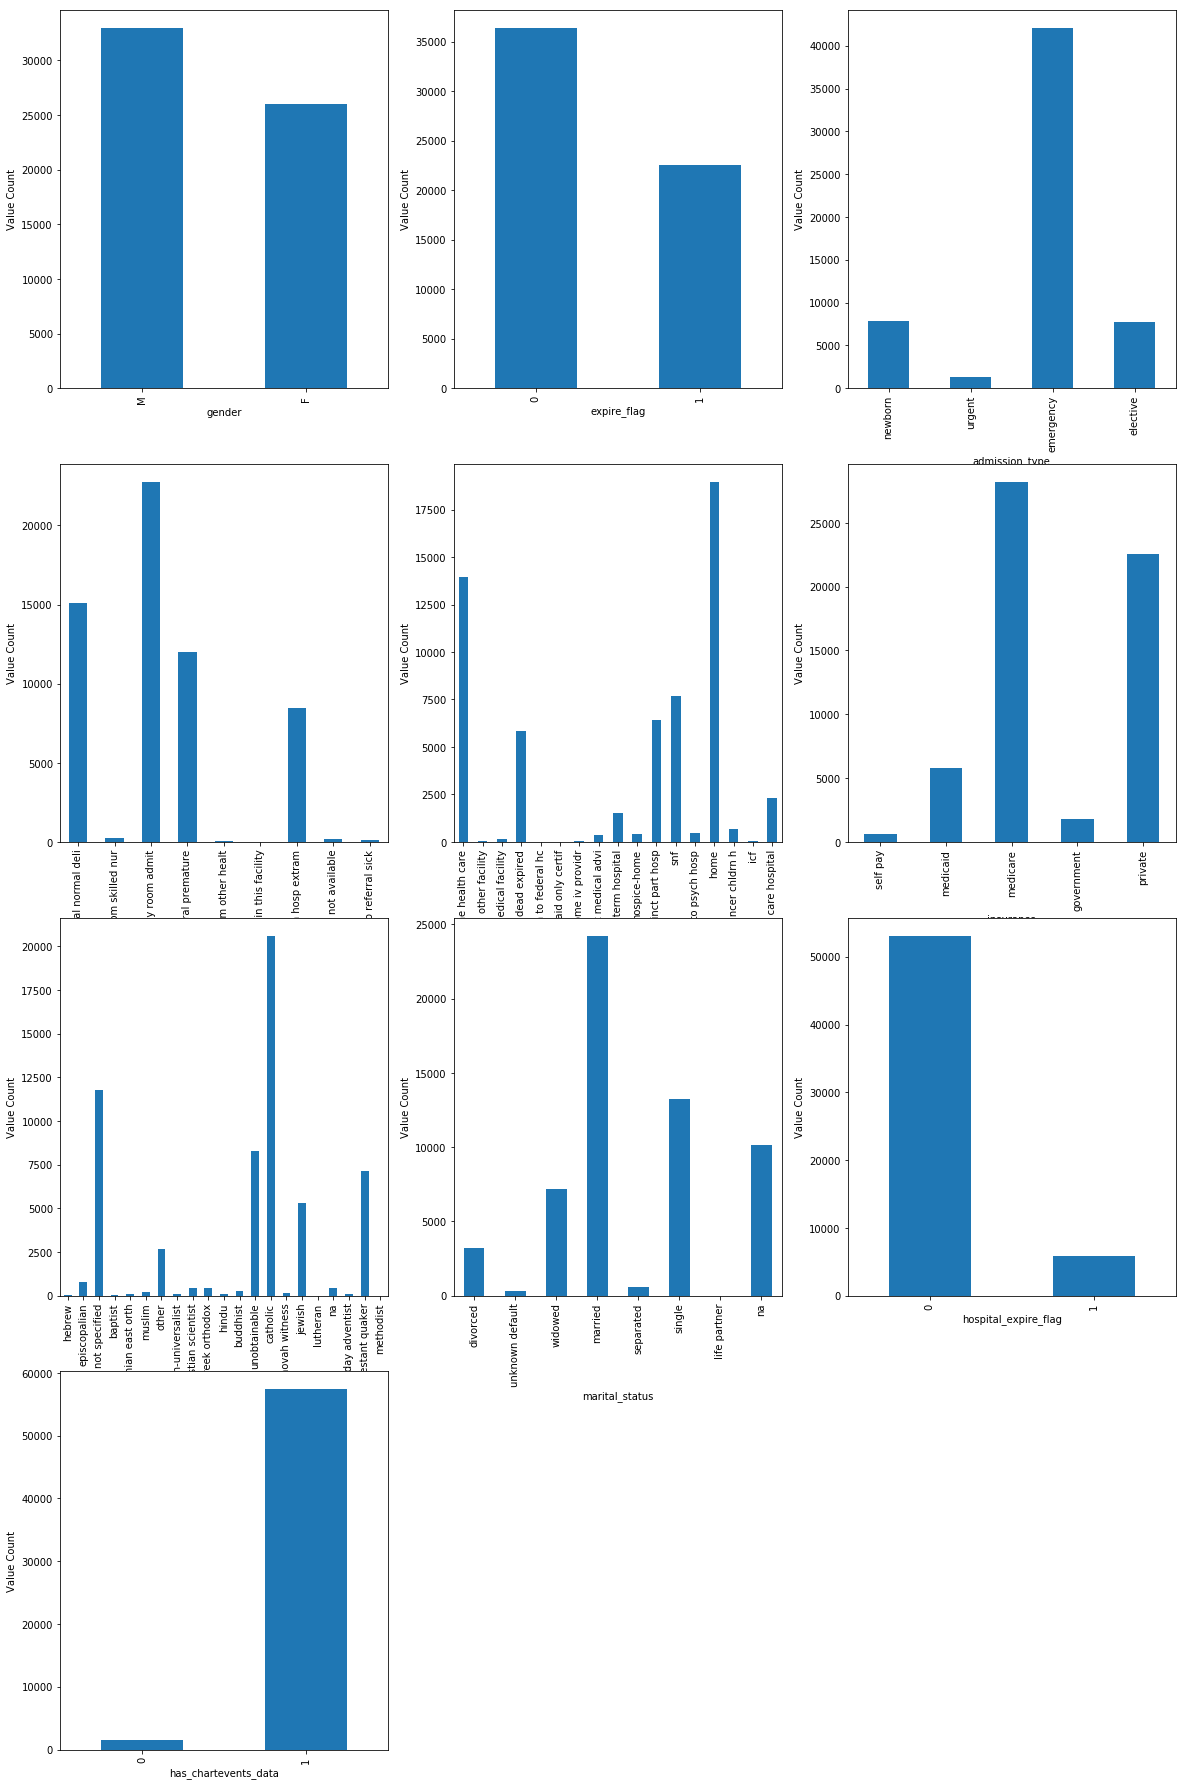

In [9]:
categorical_columns = [
    'gender',
    'expire_flag',
    'admission_type', 
    'admission_location', 
    'discharge_location', 
    'insurance', 
    'religion',
    'marital_status',
    'hospital_expire_flag',
    'has_chartevents_data',
]

num_cols = 3
num_rows = math.ceil(len(categorical_columns)/3)

plt.figure(figsize=(20, 8*num_rows))

for col in range(len(categorical_columns)):    
    plt.subplot(num_rows, num_cols, col+1)
    df_data[categorical_columns[col]].value_counts(sort=False).plot(kind='bar')
    plt.xlabel(categorical_columns[col])
    plt.ylabel('Value Count')
plt.show()

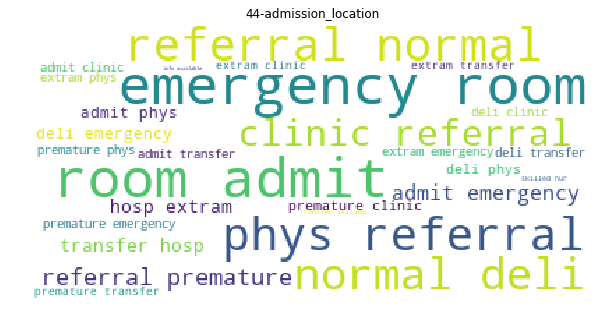

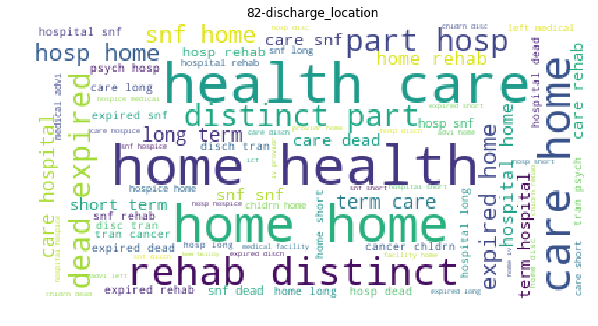

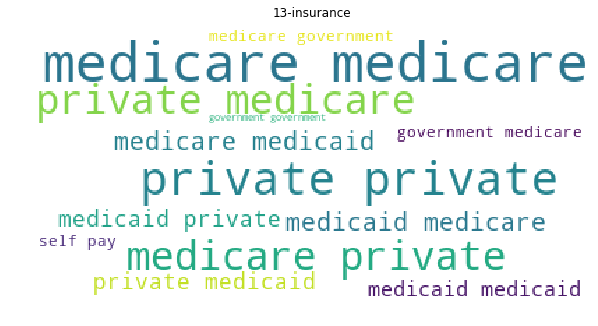

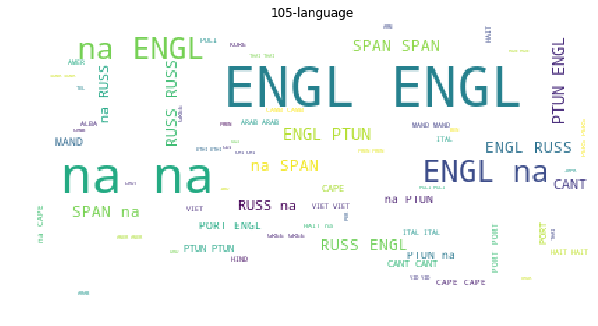

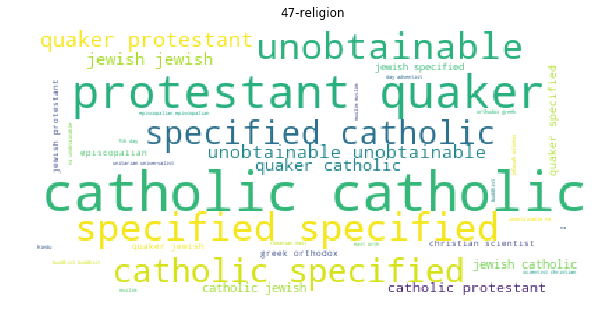

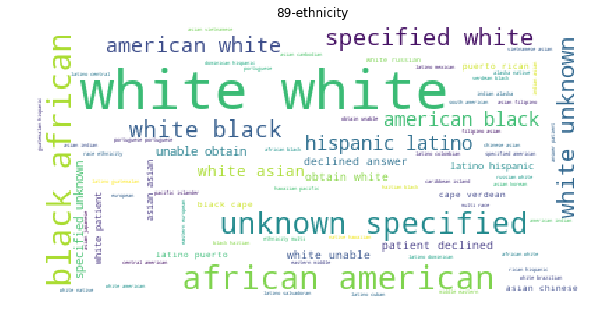

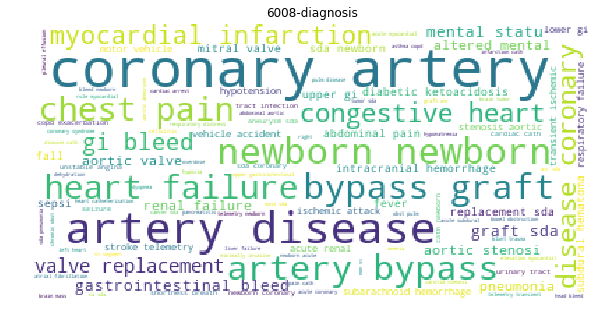

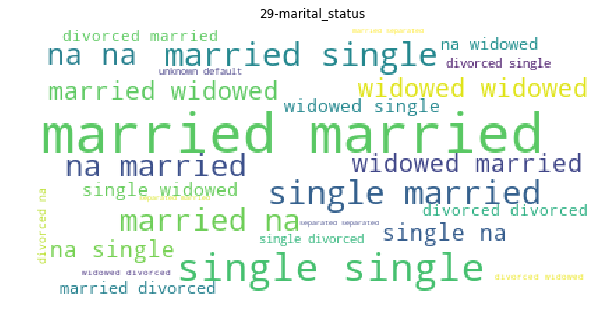

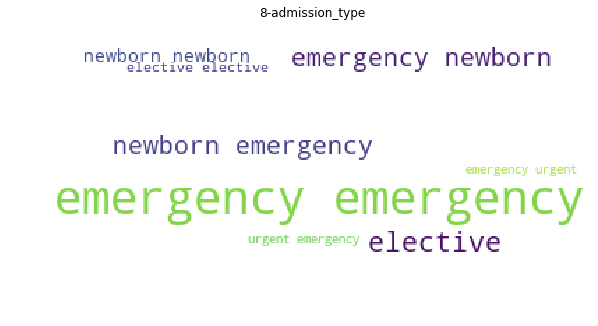

In [10]:
text_columns = [
    'admission_location', 
    'discharge_location', 
    'insurance', 
    'language', 
    'religion', 
    'ethnicity', 
    'diagnosis',
    'marital_status',
    'admission_type'
]

for col in range(len(text_columns)):
    si=StringIO()
    df_data[text_columns[col]].apply(lambda x: si.write(str(x) + " "))
    text=si.getvalue()
    si.close()

    wordcloud = WordCloud(width=1600, height=1600, max_words=100).generate(text)
    wordcloud = WordCloud(
        background_color="white",
        max_words=len(text),
        max_font_size=40, 
        relative_scaling=.5
    ).generate(text)
    plt.figure(figsize=(10, 20))
    plt.imshow(wordcloud)
    plt.title("{}-{}".format(str(len(wordcloud.words_)), text_columns[col]))
    plt.axis("off")
    plt.show()

### Definition of Ally and Adversary Variables.
- Ally target: Survived
- Adversary target: Sex
- The choice of adversary target can be changed.
- Chosen M/F here as it will be possible to have train-test split or k-fold validation

In [ ]:
df_data = pd.get_dummies(df_data, columns=['gender'], drop_first=True)
df_data = pd.get_dummies(df_data, columns=[
    'admission_location', 
    'discharge_location',
    'insurance', 
    'language', 
    'religion', 
    'ethnicity',
    'marital_status',
    'admission_type'
])
df_data.head()

In [13]:
y_ally = np.array(df_data.expire_flag.tolist())
y_advr = np.array(df_data.gender_M.tolist())

df_data.drop(['expire_flag', 'gender_M'], axis=1, inplace=True)

- using One hot encoding to convert the categorical data into dummy variables.
- Alternatively: [Managing categorical variables in pandas dataframe](http://benalexkeen.com/mapping-categorical-data-in-pandas/)
- Using count vectorizer to convert the text data into features based on bow model.

In [14]:
vectorizer = CountVectorizer(vocabulary=wordcloud.words_.keys())
diagnosis = vectorizer.fit_transform(df_data.diagnosis.tolist()).toarray()

In [15]:
df_data.drop(['diagnosis'], axis=1, inplace=True)
df_data.head(3)

,hospital_expire_flag,has_chartevents_data,dob_year,dob_month,dob_day,admittime_year,admittime_month,admittime_day,dischtime_year,dischtime_month,...,marital_status_married,marital_status_na,marital_status_separated,marital_status_single,marital_status_unknown default,marital_status_widowed,admission_type_elective,admission_type_emergency,admission_type_newborn,admission_type_urgent
0,0,1,2138,7,17,2138,7,17,2138,7,...,0,1,0,0,0,0,0,0,1,0
1,0,1,2025,4,11,2101,10,20,2101,10,...,1,0,0,0,0,0,0,1,0,0
2,0,1,2143,5,12,2191,3,16,2191,3,...,0,0,0,1,0,0,0,1,0,0


In [16]:
X = np.concatenate((df_data.values, diagnosis), axis=1)
y_ally.shape, y_advr.shape, X.shape

((58976,), (58976,), (58976, 209))

### Train Test Split

- This step is required before the Scaling or PCA is learnt on the train dataset and then used to transform the test dataset.

In [17]:
X_train, X_valid, y_ally_train, y_ally_valid, y_advr_train, y_advr_valid = train_test_split(
    X, 
    y_ally,
    y_advr,
    test_size=0.1,
    stratify=pd.DataFrame(np.concatenate((y_ally.reshape(-1, 1), y_advr.reshape(-1, 1)), axis=1))
)
X_train.shape, X_valid.shape, y_ally_train.shape, y_ally_valid.shape, y_advr_train.shape, y_advr_valid.shape

((53078, 209), (5898, 209), (53078,), (5898,), (53078,), (5898,))

### Checking the distribution after the split

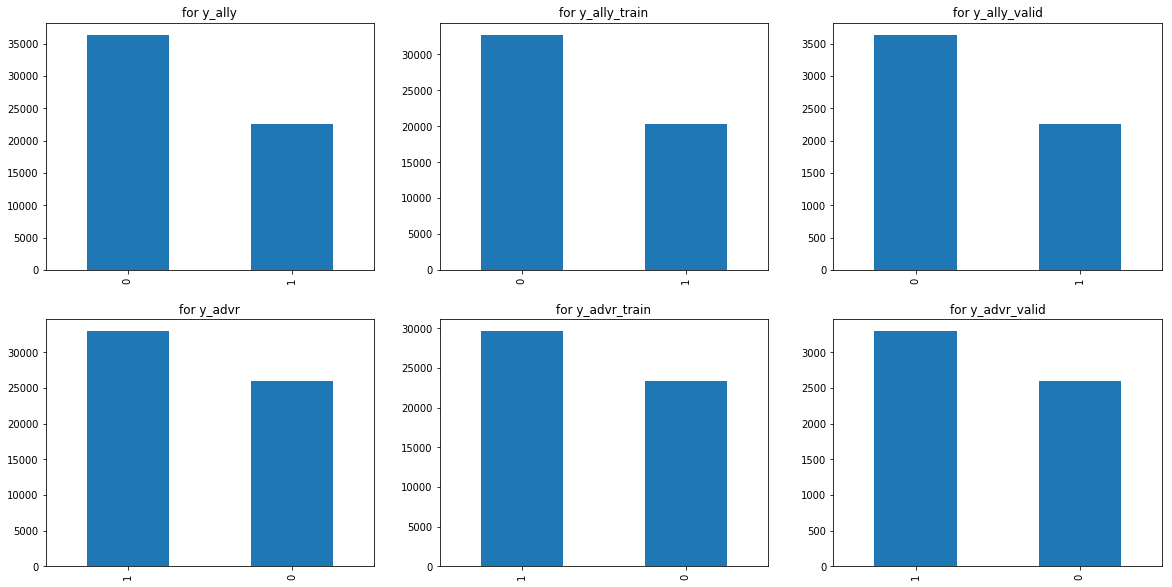

In [18]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 3, 1)
pd.value_counts(y_ally).plot(kind='bar')
plt.title('for y_ally')
plt.subplot(2, 3, 2)
pd.value_counts(y_ally_train).plot(kind='bar')
plt.title('for y_ally_train')
plt.subplot(2, 3, 3)
pd.value_counts(y_ally_valid).plot(kind='bar')
plt.title('for y_ally_valid')
plt.subplot(2, 3, 4)
pd.value_counts(y_advr).plot(kind='bar')
plt.title('for y_advr')
plt.subplot(2, 3, 5)
pd.value_counts(y_advr_train).plot(kind='bar')
plt.title('for y_advr_train')
plt.subplot(2, 3, 6)
pd.value_counts(y_advr_valid).plot(kind='bar')
plt.title('for y_advr_valid')
plt.show()

### Scaler
- Perform minmax scaling for removing the skewness which might effect the gradient descent during neural network training. 
- It is necessary to do this scaling before PCA is applied

In [19]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_valid_normalized = scaler.transform(X_valid)

### Apply PCA and select components using explained variances

In [20]:
pca = PCA()
X_train_reduced = pca.fit_transform(X_train_normalized)

In [21]:
num_components = 0
total_var = 0
variance_threshold = 0.99
for _ in pca.explained_variance_ratio_:
    total_var += _
    num_components += 1
    if total_var > variance_threshold:
        break
print(total_var, num_components)

0.9912907810694928 178


In [22]:
pca = PCA(n_components=num_components)
X_train_reduced = pca.fit_transform(X_train_normalized)
X_valid_reduced = pca.transform(X_valid_normalized)
X_train_reduced.shape, X_valid_reduced.shape

((53078, 178), (5898, 178))

### Apply Auto-encoders for dimensionality reduction

In [23]:
import torch
import torch.utils.data as utils
import torch.nn as nn

In [24]:
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print("DType: {}\nCuda available: {}\nDevice: {}".format(
    dtype.__str__(),
    torch.cuda.is_available().__str__(),
    device.__str__(),
))

DType: torch.float32
Cuda available: True
Device: cuda


In [25]:
X_train_torch = torch.Tensor(X_train_normalized).to(device)
X_valid_torch = torch.Tensor(X_valid_normalized).to(device)
y_ally_train_torch = torch.Tensor(y_ally_train.reshape(-1, 1)).to(device)
y_ally_valid_torch = torch.Tensor(y_ally_valid.reshape(-1, 1)).to(device)
y_advr_train_torch = torch.Tensor(y_advr_train.reshape(-1, 1)).to(device)
y_advr_valid_torch = torch.Tensor(y_advr_valid.reshape(-1, 1)).to(device)

In [26]:
X_train_torch.shape, X_valid_torch.shape, \
y_ally_train_torch.shape, y_ally_valid_torch.shape, \
y_advr_train_torch.shape, y_advr_valid_torch.shape

(torch.Size([53078, 209]),
 torch.Size([5898, 209]),
 torch.Size([53078, 1]),
 torch.Size([5898, 1]),
 torch.Size([53078, 1]),
 torch.Size([5898, 1]))

In [27]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.input_size = input_size
        self.encoding_dim = encoding_dim
        
        self.fc1 = torch.nn.Linear(self.input_size, self.encoding_dim)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.encoding_dim, self.input_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def encoder(self, x):
        return self.relu(self.fc1(x))

    def decoder(self, y):
        return self.sigmoid(self.fc2(y))
    
    def forward(self, x):
        y = self.encoder(x)
        x = self.decoder(y)
        return x

In [28]:
auto_encoder = AutoEncoder(input_size=X_train_normalized.shape[1], encoding_dim=X_train_reduced.shape[1]).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
ae_optimizer = optimizer(auto_encoder.parameters(), lr = 0.001)

In [29]:
print("epoch \t Aencoder_train \t Aencoder_valid")

ae_epoch = []
ae_train = []
ae_valid = []

for epoch in range(501):
    auto_encoder.train()
    ae_optimizer.zero_grad()
    
    X_train_torch_hat = auto_encoder(X_train_torch)
    ae_loss = criterion(X_train_torch_hat, X_train_torch)
    ae_loss.backward(retain_graph=True)
    ae_optimizer.step()
    
    if epoch%50!=0:
        continue
        
    auto_encoder.eval()
    
    X_valid_torch_hat = auto_encoder(X_valid_torch)
    ae_valid_loss = criterion(X_valid_torch_hat, X_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        ae_loss.item(),
        ae_valid_loss.item()
    ))
    
    ae_epoch.append(epoch)
    ae_train.append(ae_loss.item())
    ae_valid.append(ae_valid_loss.item())

epoch 	 Aencoder_train 	 Aencoder_valid
0 	 0.97472078 	 0.96971589
50 	 0.69729829 	 0.69550240
100 	 0.66758794 	 0.66709948
150 	 0.65819550 	 0.65783542
200 	 0.65354502 	 0.65317804
250 	 0.64959764 	 0.64920247
300 	 0.64649552 	 0.64615196
350 	 0.64363068 	 0.64330059
400 	 0.64069170 	 0.64034200
450 	 0.63856912 	 0.63828385
500 	 0.63676924 	 0.63648313


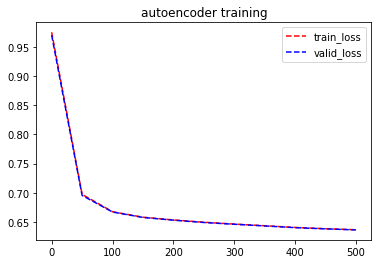

In [30]:
plt.plot(ae_epoch, ae_train, 'r--')
plt.plot(ae_epoch, ae_valid, 'b--')
plt.legend(['train_loss', 'valid_loss'])
plt.title("autoencoder training")
plt.show()

In [31]:
auto_encoder.eval()
X_train_torch_ae = auto_encoder.encoder(X_train_torch)
X_valid_torch_ae = auto_encoder.encoder(X_valid_torch)
X_train_torch_ae.shape, X_valid_torch_ae.shape

(torch.Size([53078, 178]), torch.Size([5898, 178]))

# GAN using Pytorch

- ["**Learning Informative and Private Representations via Generative Adversarial Networks**"](http://www.princeton.edu/~pmittal/publications/gan-bigdata18.pdf)

### GAN V1

```python
encd_N = 64 
encd_D_in = X.shape[1]
encd_H = int(encd_D_in/2)
encd_D_out = 64

# encoder
encd_w1 = torch.randn(encd_D_in, encd_H, device=device, dtype=dtype, requires_grad=True)
encd_w2 = torch.randn(encd_H, encd_D_out, device=device, dtype=dtype, requires_grad=True)

ally_N = 64 
ally_D_in = encd_D_out
ally_H = int(ally_D_in/2)
ally_D_out = 1

# ally
ally_w1 = torch.randn(ally_D_in, ally_H, device=device, dtype=dtype, requires_grad=True)
ally_w2 = torch.randn(ally_H, ally_D_out, device=device, dtype=dtype, requires_grad=True)

advr_N = 64 
advr_D_in = encd_D_out
advr_H = int(advr_D_in/2)
advr_D_out = 2

# advr
advr_w1 = torch.randn(advr_D_in, advr_H, device=device, dtype=dtype, requires_grad=True)
advr_w2 = torch.randn(advr_H, advr_D_out, device=device, dtype=dtype, requires_grad=True)
```

### GAN V2

In [32]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output


class Ally(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Ally, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output


class Adversary(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Adversary, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [33]:
num_epoch = 10
alpha = 0.5

In [34]:
encoding_dimension = X_train_reduced.shape[1]
encoder = Encoder(input_size=X_train_torch.shape[1], hidden_size=1024, output_size=encoding_dimension).cuda()
ally = Ally(input_size=encoding_dimension, hidden_size=64, output_size=y_ally_train_torch.shape[1]).cuda()
adversary = Adversary(input_size=encoding_dimension, hidden_size=64, output_size=y_advr_train_torch.shape[1]).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
encd_optimizer = optimizer(encoder.parameters(), lr = 0.0001)
ally_optimizer = optimizer(ally.parameters(), lr=0.00001)
advr_optimizer = optimizer(adversary.parameters(), lr=0.0001)

In [35]:
print("epoch \t encoder_train \t encoder_valid \t ally_train \t ally_valid \t advr_train \t advr_valid")

g_epoch = []
enc_train = []
enc_valid = []
ally_train = []
ally_valid = []
advr_train = []
advr_valid = []

for epoch in range(501):
    # set for training
    encoder.train()
    ally.train()
    adversary.train()
    
    encd_optimizer.zero_grad()
    # Forward passv
    X_train_encoding = encoder(X_train_torch)
    y_ally_train_torch_hat = ally(X_train_encoding)
    y_advr_train_torch_hat = adversary(X_train_encoding)
    # Compute Loss
    ally_loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    advr_loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    encd_loss = alpha * ally_loss - (1-alpha) * advr_loss
    # Backward pass
    encd_loss.backward(retain_graph=True)
    encd_optimizer.step()

    for i in range(10):
        ally_optimizer.zero_grad()
        advr_optimizer.zero_grad()

        X_train_encoding = encoder(X_train_torch)
        y_ally_train_torch_hat = ally(X_train_encoding)
        y_advr_train_torch_hat = adversary(X_train_encoding)
        
        ally_loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
        advr_loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
        
        ally_loss.backward(retain_graph=True)
        advr_loss.backward(retain_graph=True)

        ally_optimizer.step()
        advr_optimizer.step()
        
    if epoch%50!=0:
        continue

    # set for eval
    encoder.eval()
    ally.eval()
    adversary.eval()
    
    X_valid_encoding = encoder(X_valid_torch)
    y_ally_valid_torch_hat = ally(X_valid_encoding)
    y_advr_valid_torch_hat = adversary(X_valid_encoding)

    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    encd_valid_loss = alpha * ally_loss - ((1-alpha) * advr_loss)
        
    print('{} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        encd_loss.item(),
        encd_valid_loss.item(),
        ally_loss.item(), 
        ally_valid_loss.item(),
        advr_loss.item(),
        advr_valid_loss.item(),
    ))
    
    g_epoch.append(epoch)
    enc_train.append(encd_loss.item())
    enc_valid.append(encd_valid_loss.item())
    ally_train.append(ally_loss.item())
    ally_valid.append(ally_valid_loss.item())
    advr_train.append(advr_loss.item())
    advr_valid.append(advr_valid_loss.item())

epoch 	 encoder_train 	 encoder_valid 	 ally_train 	 ally_valid 	 advr_train 	 advr_valid
0 	 0.05106819 	 0.05137539 	 0.79504418 	 0.79490405 	 0.69229341 	 0.69210804
50 	 0.01837653 	 0.01799056 	 0.72206545 	 0.72175539 	 0.68608433 	 0.68607432
100 	 0.00617820 	 0.00605372 	 0.69829524 	 0.69803160 	 0.68618780 	 0.68612301
150 	 -0.00017011 	 -0.00031623 	 0.68515247 	 0.68484807 	 0.68578494 	 0.68585038
200 	 -0.00893420 	 -0.00910193 	 0.66718572 	 0.66671151 	 0.68538958 	 0.68556845
250 	 -0.01529315 	 -0.01545435 	 0.65368241 	 0.65317726 	 0.68459111 	 0.68472540
300 	 -0.01863670 	 -0.01868877 	 0.64586502 	 0.64572334 	 0.68324256 	 0.68346924
350 	 -0.02203488 	 -0.02210248 	 0.64123243 	 0.64139217 	 0.68543738 	 0.68502378
400 	 -0.02233207 	 -0.02241716 	 0.63827366 	 0.63904059 	 0.68310797 	 0.68325531
450 	 -0.02444839 	 -0.02446723 	 0.63616753 	 0.63719052 	 0.68510199 	 0.68530059
500 	 -0.02510780 	 -0.02512410 	 0.63466394 	 0.63580120 	 0.68491215 	 0.6845

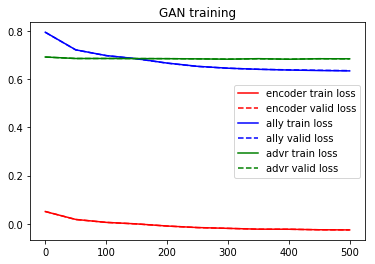

In [36]:
plt.plot(g_epoch, enc_train, 'r')
plt.plot(g_epoch, enc_valid, 'r--')
plt.plot(g_epoch, ally_train, 'b')
plt.plot(g_epoch, ally_valid, 'b--')
plt.plot(g_epoch, advr_train, 'g')
plt.plot(g_epoch, advr_valid, 'g--')
plt.legend([
    'encoder train loss', 
    'encoder valid loss',
    'ally train loss',
    'ally valid loss',
    'advr train loss',
    'advr valid loss'
])
plt.title("GAN training")
plt.show()

# Ally and Adversary Learning on Encoded Data

In [37]:
X_train_encoded = encoder(X_train_torch)
X_valid_encoded = encoder(X_valid_torch)
X_train_encoded.shape, X_valid_encoded.shape

(torch.Size([53078, 178]), torch.Size([5898, 178]))

In [38]:
X_train_reduced.shape, X_valid_reduced.shape

((53078, 178), (5898, 178))

In [39]:
y_ally_train_torch.shape, y_ally_valid_torch.shape

(torch.Size([53078, 1]), torch.Size([5898, 1]))

In [40]:
class Network(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Network, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, output_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.sigmoid(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [42]:
lr = 0.01

network = Network(X_train_reduced.shape[1], 64, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network.parameters(), lr=lr)    

print("epoch \t ally_train \t ally_valid")

n_epoch = []
train = []
valid = []
for epoch in range(501):
    network.train()
    net_optimizer.zero_grad()
    
    y_ally_train_torch_hat = network(X_train_encoded)
    loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network.eval()
    y_ally_valid_torch_hat = network(X_valid_encoded)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        ally_valid_loss.item()
    ))
    n_epoch.append(epoch)
    train.append(loss.item())
    valid.append(ally_valid_loss.item())

epoch 	 ally_train 	 ally_valid
0 	 0.78408521 	 0.71185911
50 	 0.63354272 	 0.63469481
100 	 0.63317585 	 0.63423955
150 	 0.63306439 	 0.63408589
200 	 0.63299412 	 0.63398075
250 	 0.63294291 	 0.63390702
300 	 0.63290167 	 0.63385689
350 	 0.63286859 	 0.63382727
400 	 0.63284236 	 0.63381130
450 	 0.63282090 	 0.63380128
500 	 0.63280219 	 0.63379383


In [44]:
lr = 0.001

network_advr = Network(X_train_reduced.shape[1], 64, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_advr.parameters(), lr=lr)    

print("epoch \t advr_train \t advr_valid")

train_a = []
valid_a = []

for epoch in range(501):
    network_advr.train()
    net_optimizer.zero_grad()
    
    y_advr_train_torch_hat = network_advr(X_train_encoded)
    loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_advr.eval()
    y_advr_valid_torch_hat = network_advr(X_valid_encoded)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        advr_valid_loss.item()
    ))
    
    
    train_a.append(loss.item())
    valid_a.append(advr_valid_loss.item())

epoch 	 advr_train 	 advr_valid
0 	 0.69635928 	 0.69434083
50 	 0.68573749 	 0.68561900
100 	 0.68542928 	 0.68527240
150 	 0.68534130 	 0.68516695
200 	 0.68524891 	 0.68506551
250 	 0.68514216 	 0.68494833
300 	 0.68500841 	 0.68480062
350 	 0.68482924 	 0.68460685
400 	 0.68458462 	 0.68434221
450 	 0.68424648 	 0.68397474
500 	 0.68376684 	 0.68345159


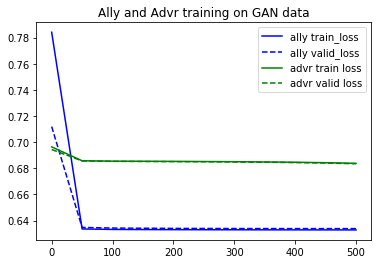

In [45]:
plt.plot(n_epoch, train, 'b')
plt.plot(n_epoch, valid, 'b--')
plt.plot(n_epoch, train_a, 'g')
plt.plot(n_epoch, valid_a, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on GAN data")
plt.show()

# Ally and Adversary Learning on PCA Data

In [46]:
X_train_pca_torch = torch.Tensor(X_train_reduced).to(device)
X_valid_pca_torch = torch.Tensor(X_valid_reduced).to(device)

In [48]:
lr = 0.01

network_ally_pca = Network(X_train_reduced.shape[1], 64, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_ally_pca.parameters(), lr=lr)    

print("epoch \t ally_train \t ally_valid")


pca_ally_train = []
pca_ally_valid = []

for epoch in range(501):
    network_ally_pca.train()
    net_optimizer.zero_grad()
    
    y_ally_train_torch_hat = network_ally_pca(X_train_pca_torch)
    loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_ally_pca.eval()
    y_ally_valid_torch_hat = network_ally_pca(X_valid_pca_torch)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        ally_valid_loss.item()
    ))
    
    
    pca_ally_train.append(loss.item())
    pca_ally_valid.append(ally_valid_loss.item())

epoch 	 ally_train 	 ally_valid
0 	 0.79765409 	 0.77173120
50 	 0.64846367 	 0.64715201
100 	 0.63737398 	 0.63739485
150 	 0.63537729 	 0.63622659
200 	 0.63368958 	 0.63565528
250 	 0.63196039 	 0.63535750
300 	 0.63020176 	 0.63517737
350 	 0.62843746 	 0.63521600
400 	 0.62673998 	 0.63522249
450 	 0.62509000 	 0.63538098
500 	 0.62350148 	 0.63539982


In [50]:
lr = 0.001

network_advr_pca = Network(X_train_reduced.shape[1], 64, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_advr_pca.parameters(), lr=lr)    

print("epoch \t advr_train \t advr_valid")

pca_advr_train = []
pca_advr_valid = []

for epoch in range(501):
    network_advr_pca.train()
    net_optimizer.zero_grad()
    
    y_advr_train_torch_hat = network_advr_pca(X_train_pca_torch)
    loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_advr_pca.eval()
    y_advr_valid_torch_hat = network_advr_pca(X_valid_pca_torch)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        advr_valid_loss
    ))
    
    
    pca_advr_train.append(loss.item())
    pca_advr_valid.append(advr_valid_loss.item())

epoch 	 advr_train 	 advr_valid
0 	 0.69816905 	 0.69734532
50 	 0.67759180 	 0.67830604
100 	 0.67129397 	 0.67195213
150 	 0.66704696 	 0.66747355
200 	 0.66466075 	 0.66509879
250 	 0.66338140 	 0.66394937
300 	 0.66258448 	 0.66331583
350 	 0.66195053 	 0.66282570
400 	 0.66131568 	 0.66233414
450 	 0.66058815 	 0.66183573
500 	 0.65974653 	 0.66131884


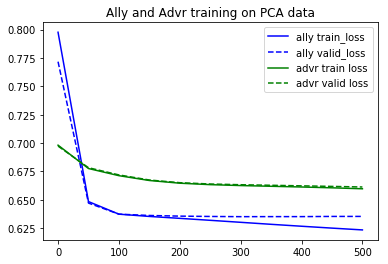

In [51]:
plt.plot(n_epoch, pca_ally_train, 'b')
plt.plot(n_epoch, pca_ally_valid, 'b--')
plt.plot(n_epoch, pca_advr_train, 'g')
plt.plot(n_epoch, pca_advr_valid, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on PCA data")
plt.show()

# Ally and Adversary Training on Auto-encoded data

In [53]:
lr = 0.01

network_ally_ae = Network(X_train_reduced.shape[1], 64, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_ally_ae.parameters(), lr=lr)    

print("epoch \t ally_train \t ally_valid")


ae_ally_train=[]
ae_ally_valid = []

for epoch in range(501):
    network_ally_ae.train()
    net_optimizer.zero_grad()
    
    y_ally_train_torch_hat = network_ally_ae(X_train_torch_ae)
    loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_ally_ae.eval()
    y_ally_valid_torch_hat = network_ally_ae(X_valid_torch_ae)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        ally_valid_loss
    ))
    
    ae_ally_train.append(loss.item())
    ae_ally_valid.append(ally_valid_loss)

epoch 	 ally_train 	 ally_valid
0 	 0.75047714 	 0.70723993
50 	 0.64078677 	 0.63804126
100 	 0.63695270 	 0.63556647
150 	 0.63554078 	 0.63514364
200 	 0.63455075 	 0.63508511
250 	 0.63358355 	 0.63499415
300 	 0.63252676 	 0.63495868
350 	 0.63136727 	 0.63492662
400 	 0.63009453 	 0.63486981
450 	 0.62873727 	 0.63476241
500 	 0.62733650 	 0.63468724


In [54]:
lr = 0.001

network_advr_ae = Network(X_train_reduced.shape[1], 64, 1).cuda()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_advr_ae.parameters(), lr=lr)    

print("epoch \t advr_train \t advr_valid")

ae_advr_train = []
ae_advr_valid = []
for epoch in range(501):
    network_advr_ae.train()
    net_optimizer.zero_grad()
    
    y_advr_train_torch_hat = network_advr_ae(X_train_torch_ae)
    loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_advr_ae.eval()
    y_advr_valid_torch_hat = network_advr_ae(X_valid_torch_ae)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        advr_valid_loss
    ))
    
    ae_advr_train.append(loss.item())
    ae_advr_valid.append(advr_valid_loss.item())

epoch 	 advr_train 	 advr_valid
0 	 0.69718194 	 0.69474894
50 	 0.67752677 	 0.67684561
100 	 0.66928750 	 0.66806245
150 	 0.66577244 	 0.66454333
200 	 0.66420007 	 0.66280699
250 	 0.66315579 	 0.66173869
300 	 0.66224778 	 0.66100621
350 	 0.66138017 	 0.66048896
400 	 0.66051865 	 0.66008896
450 	 0.65963399 	 0.65978378
500 	 0.65869755 	 0.65955931


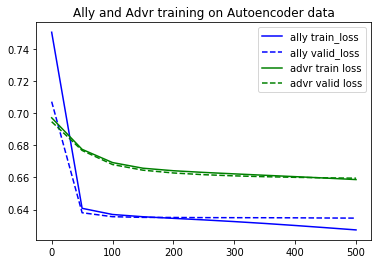

In [55]:
plt.plot(n_epoch, ae_ally_train, 'b')
plt.plot(n_epoch, ae_ally_valid, 'b--')
plt.plot(n_epoch, ae_advr_train, 'g')
plt.plot(n_epoch, ae_advr_valid, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on Autoencoder data")
plt.show()

# Results

| Model | Train Ally  | Valid Ally  | Train Advr | Valid Advr |
|---|---:|---:|---:|---:|
| PCA | 0.62237549 | 0.63795388 | 0.65854299 | 0.66764313 |
| A-Enc | 0.62899935 | **0.63755053** | 0.65798354 | 0.66843909 |
| P-GAN | **0.61490375** | 0.63841212 | **0.68383056** | **0.68446696** |

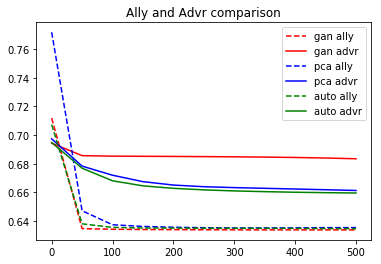

In [56]:
plt.plot(n_epoch, valid, 'r--')
plt.plot(n_epoch, valid_a, 'r')
plt.plot(n_epoch, pca_ally_valid, 'b--')
plt.plot(n_epoch, pca_advr_valid, 'b')
plt.plot(n_epoch, ae_ally_valid, 'g--')
plt.plot(n_epoch, ae_advr_valid, 'g')
plt.legend(['gan ally', 'gan advr', 'pca ally', 'pca advr', 'auto ally', 'auto advr'])
plt.title("Ally and Advr comparison")
plt.show()